In [9]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from matplotlib import pylab as plt
################################################################################################################
############################ Global Initialization #############################################################
targetAttribute = 'Poisonous/Edible'
targetValue = []
predictedList= []
# maxGainAttr:  spore-print-color    if  maxInfoGain > 0.144354902043, we get the data classified incorrectly
minimalGainThreshold =0.144
defaultTargetValue = 'p'
rawDataSet = 'MushroomDataSet_Before_PreProcessing.xlsx'
processedDataSet = 'MushroomDataSet_After_PreProcessing.xlsx'
columnToProcess = 'stalk-root'
res = {}
################################################################################################################
################################### Finding the set of Target Value ############################################
def initializeList(data):
    groupedData = data.groupby([targetAttribute]).groups.keys()
    return groupedData
################################################################################################################
################################## Creating the Tree Recursively ###############################################
def createTree(df):
    x = df.drop(labels=targetAttribute, axis=1)
    y = df[targetAttribute] 
    ##Returning the original Set if no further split can be made######## 
    if len(y) == 0:
        return y

    if trueSet(y):
        return set(y).pop()
    
    ##Finding the attribute which gives maximal information#############
    
    maxGainAttr,maxInfoGain = calcInforGainForEachAtrribute(df)
##If the information gain is less than the threshold set we classify as 'Poisonous' instead of saying it edible##
    if((maxGainAttr== None) and (maxInfoGain == None)):
        return defaultTargetValue
##################################################################################################################
##### If there is an information gain we recursively do splits ##################################################
    sets = df.groupby(maxGainAttr)
    for k, v in sets:
        res["%s = %s" % (maxGainAttr, k)] = createTree(v)
    return res
##################################################################################################################
######################## Information Gain Calculator ############################################################
def calcInforGainForEachAtrribute(df):
    # return maximum info gain
    maxInfoGain =0;
    infoGainDict = {}
    attributes = list(df)
    totalEntropy = entropy(df)

    for att in attributes:
        #don't calculate gain for target attribute
        if (att ==targetAttribute ):
            continue
        grouped_data = df.groupby([att], as_index=False)
        totalRows = len(df)
        subEntropy = 0
        for key, value in grouped_data:
            eachGroupRows = len(value)
            S = entropy(value)
            #calculate |Sv/S|
            valEntrpy = eachGroupRows / totalRows
            #calculate |Sv/S|*Entropy(Sv)
            subEntropy = subEntropy + valEntrpy * S
        individualEntrpyGain = totalEntropy - subEntropy
        infoGainDict[att] = individualEntrpyGain
        if (individualEntrpyGain > maxInfoGain):
            maxInfoGain = individualEntrpyGain
            maxGainAttr = att;
    # If there's no gain at all, nothing has to be done, just return the original set
    if (maxInfoGain < minimalGainThreshold):
        return None, None
    else:
        return maxGainAttr,maxInfoGain
##################################################################################################################
######################### Evaluating if a Pure Set is reached ?################################################### 
def trueSet(s):
    return len(set(s)) == 1
###################################################################################################################
########################### Entropy Calculator ######################################################################
def entropy(df):
    #target unique value calculation in form of dictionary 
    targetDict = pd.value_counts(df[targetAttribute]).to_dict()
    dfLength =len(df) 
    totalEntropy = 0
    for key, val in targetDict.items():
        multipleVal = val/dfLength
        totalEntropy += multipleVal * math.log2(multipleVal)
    return 0-totalEntropy
##################################################################################################################
########################## Evaluating the Test Data by Passing the Learned tree and Test Data as Parameters #####
def predictTarget(targetDict,test):
    for k,v in targetDict.items():
        keyList = k.split('=')
        col = keyList[0].strip()
        val = keyList[1].strip()
        if(test[col].iloc[0] == val):
            if k in targetDict:
                temp = targetDict.get(k)
                if(type(temp) == dict):
                    return predictTarget(v,test)
                else:
                    return v
##################################################################################################################
########################### Printing the Confusion Matrix #######################################################
def printMatrix(y_test,predictedList,labels):
    cm = confusion_matrix(y_test, pd.Series(predictedList), labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
####################################################################################################################
####################################### Main Function ############################################################


In [10]:
def main():
    ########### Data Pre-Processing by filling up most Frequent items for the Missing Values#############
    ########### Training and the test data split at the rate of 80/20 ###################################
    datasetforProcessing = pd.read_excel(rawDataSet)
    x = datasetforProcessing.iloc[:, 11].values
    df1 = datasetforProcessing.fillna(datasetforProcessing[columnToProcess].value_counts().index[0])
    writer = pd.ExcelWriter(processedDataSet, engine='xlsxwriter')
    df1.to_excel(writer, sheet_name='Sheet1')
    writer.save()
    datasetAfterProcessing = pd.read_excel(processedDataSet)
    X = datasetAfterProcessing.drop(labels=targetAttribute, axis=1)
    y = datasetAfterProcessing[targetAttribute]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)
    X_train[targetAttribute] = y_train
    ####################################################################################################
    ##################### Creating the distinct values for the Target Value ############################
    targetValue = initializeList(X_train)
    ####################################################################################################
    ###################### Tree Builder by calculating the entropy and Information gain Recursively#####
    
    targetDict = createTree(X_train)
    ####################################################################################################
    X_train =X_train.drop(targetAttribute,axis =1)
    for i in list(range(0,len(X_train))):
        predictedVal = predictTarget(targetDict,X_train.iloc[[i]])
        predictedList.append(predictedVal)
    printMatrix(y_train,predictedList,list(targetValue))
   


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[[3329   36]
 [ 199 2935]]


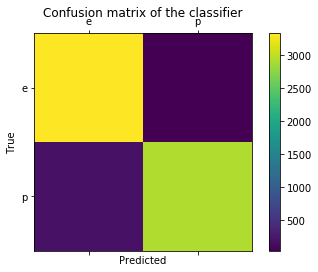

In [11]:
main()